# TCN

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed, Lambda

from scipy.stats import pearsonr

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
lookback = 100
pred_length = 20
length_pred = pred_length
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

(5429, 114)


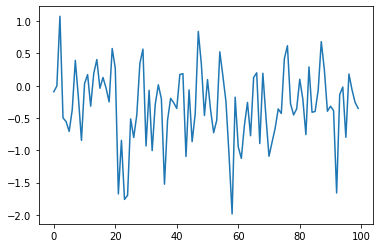

In [7]:
plt.plot(train_generator[0][0][0])

In [4]:
# Model Architecture
input_layer = Input(shape=(None, electrode_count))
x = TCN(nb_filters=32,
        kernel_size=4,
        dilations=[1, 2, 4, 8, 16],
        nb_stacks=2,
        padding="causal",
        use_skip_connections=True,
        return_sequences=True,
        activation="linear",
        dropout_rate=0.05,
        kernel_initializer="he_normal")(input_layer)
x = Dense(1)(x)
# Workaround because config does not work with copy.deepcopy
# https://github.com/wandb/client/issues/833 fix does not work
length_pred = 20
x = Lambda(lambda x: x[:, -length_pred:, :])(x)
output_layer = x
model = Model(input_layer, output_layer)
model.compile(optimizer=Adam(), loss="mae")
model.summary()

(None, None, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
tcn (TCN)                    (None, None, 32)          92128     
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 92,161
Trainable params: 92,161
Non-trainable params: 0
_________________________________________________________________


In [5]:
train_generator[0][0].shape

(1024, 100, 1)

In [6]:
train_generator[0][1].shape

(1024, 20, 1)

In [7]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=2,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 4 steps
Epoch 1/100
12/12 [==============================] - 12s 1s/step - loss: 47.7822 - val_loss: 10.6827
Epoch 2/100
12/12 [==============================] - 4s 318ms/step - loss: 10.2174 - val_loss: 4.2153
Epoch 3/100
12/12 [==============================] - 4s 324ms/step - loss: 4.8184 - val_loss: 2.3466
Epoch 4/100
12/12 [==============================] - 4s 317ms/step - loss: 2.9925 - val_loss: 1.6589
Epoch 5/100
12/12 [==============================] - 4s 320ms/step - loss: 2.1800 - val_loss: 1.2931
Epoch 6/100
12/12 [==============================] - 4s 317ms/step - loss: 1.7300 - val_loss: 1.0885
Epoch 7/100
12/12 [==============================] - 4s 319ms/step - loss: 1.4427 - val_loss: 0.9526
Epoch 8/100
12/12 [==============================] - 4s 319ms/step - loss: 1.2499 - val_loss: 0.8684
Epoch 9/100
12/12 [=====

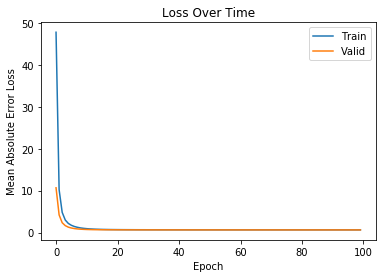

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [9]:
from tensorflow.keras.models import model_from_json

file_name = "models/tcn_o2o"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


In [45]:
from tensorflow.keras.models import model_from_json
file_name = "models/tcn_o2o"

# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'TCN': TCN})
# load weights into new model
model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

(None, None, 1)
Loaded model from disk


In [46]:
def predict_sequence_o2o(input_sequence, pred_steps, model):
    lookback = input_sequence.shape[1]
#     print(input_sequence.shape)
    history_sequence = input_sequence.reshape((1, lookback, 1))
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
        last_step_pred = last_step_pred.reshape(-1)

        pred_sequence[i] = last_step_pred[-1]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           last_step_pred[-1].reshape(1, 1, 1)], axis=1)

    return pred_sequence

In [47]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int, enc_tail_len=100):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    pred_series = predict_sequence_o2o(encode_series,
                                              pred_steps, model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    print(f"Correlation: {r}. P: {p}. Mae: {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [48]:
val_batch = val_generator[0]

In [49]:
len(val_batch[0][0])

100

Correlation: 0.1969632570530397. P: 0.4052234184600765. Mae: 0.4693659239824834


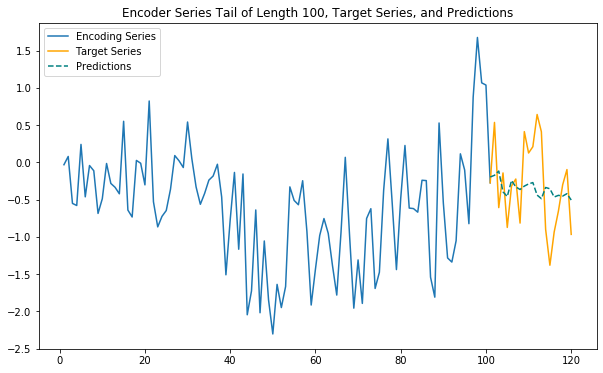

In [14]:
predict_and_plot(val_batch[0], val_batch[1], sample_ix=0, pred_steps=20)

In [50]:
def get_corr_mae(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int,
                 enc_tail_len=100, verbose=True):
    encode_series = encoder_input_data[sample_ix:sample_ix+1,:,:] 
    pred_series = predict_sequence_o2o(encode_series,
                                              pred_steps, model)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [16]:
encoder_input_data = val_batch[0]
encoder_target_data = val_batch[1]

In [17]:
n_rows = int(encoder_input_data.shape[0]//2)
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(encoder_input_data, encoder_target_data, sample_ix=sample_ix, pred_steps=20, verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.026237048365064936
Absolute Batch_r: 0.21711702510291758
Batch Mae: 0.6209536367526519


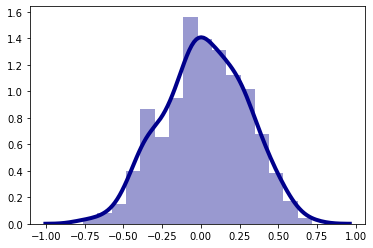

In [18]:

# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [21]:
k = 5
top_k_r = np.abs(r_array).argsort()[-k:]
print(top_k_r)

[ 96 307 408 503 356]


Correlation: -0.661366551392485. P: 0.0014958317417334349. Mae: 0.5968365512358833
Correlation: 0.7123285842439142. P: 0.0004253944713475606. Mae: 0.5086919660734124
Correlation: 0.718602094128354. P: 0.0003578617203784451. Mae: 0.7885061295008826
Correlation: -0.7561849125994295. P: 0.00011461700848466267. Mae: 0.8293274876608571
Correlation: -0.7601813329991339. P: 0.00010036685985868573. Mae: 0.6669101823345939


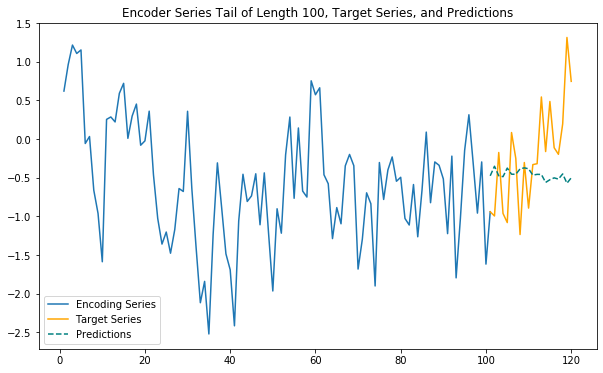

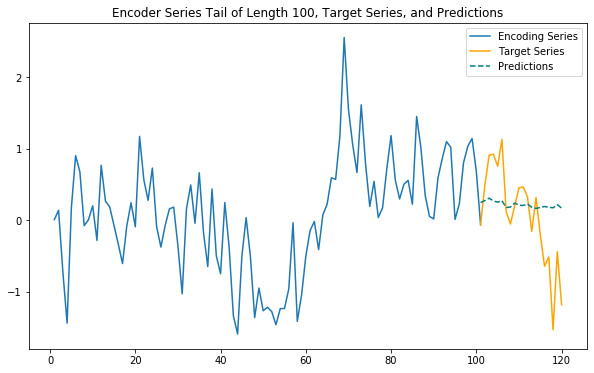

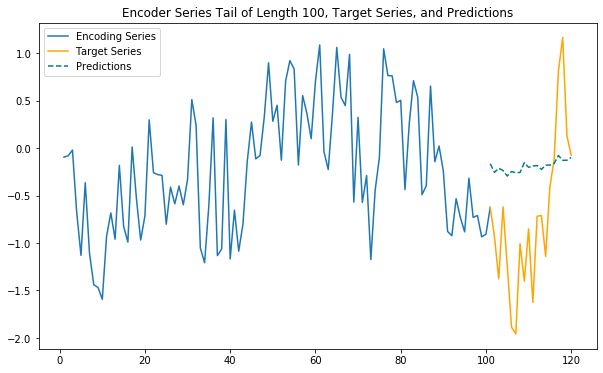

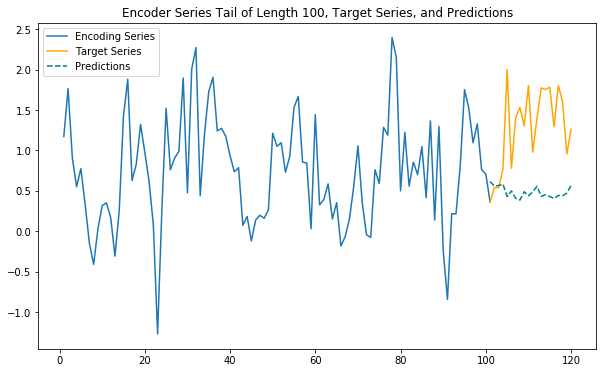

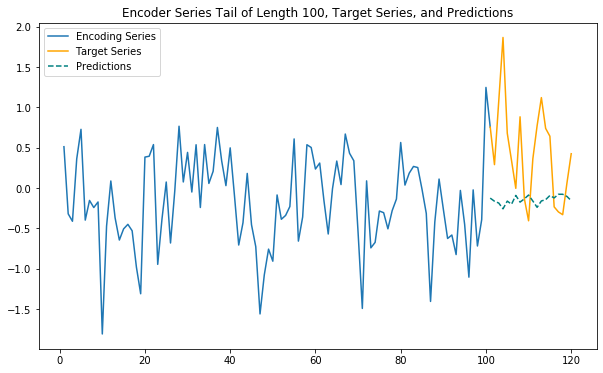

In [22]:
for i in top_k_r:
    predict_and_plot(val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=20)

In [23]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[110 188 111 477 505]


Correlation: 0.2771307401640854. P: 0.23684466164463622. Mae: 0.18646730902149694
Correlation: 0.3101277545127431. P: 0.18328066524041833. Mae: 0.263490606960736
Correlation: 0.31028024304926405. P: 0.18305406441806682. Mae: 0.27360606669429355
Correlation: -0.10810465826798686. P: 0.6500716489511831. Mae: 0.3009018686128052
Correlation: 0.1721338944476501. P: 0.4680332029609887. Mae: 0.30475304608914505


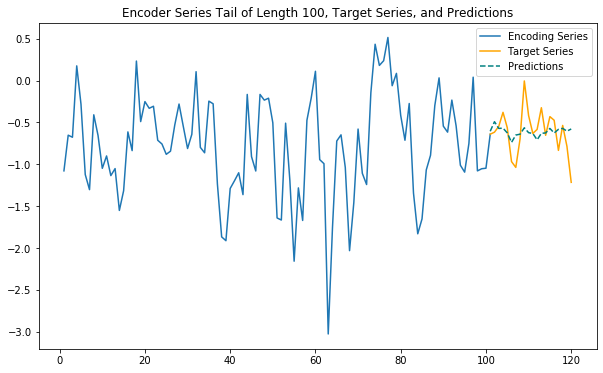

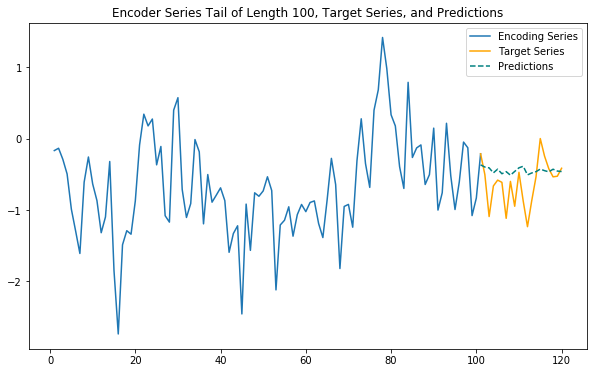

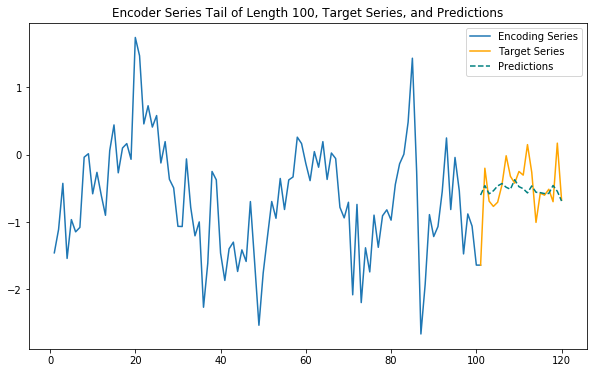

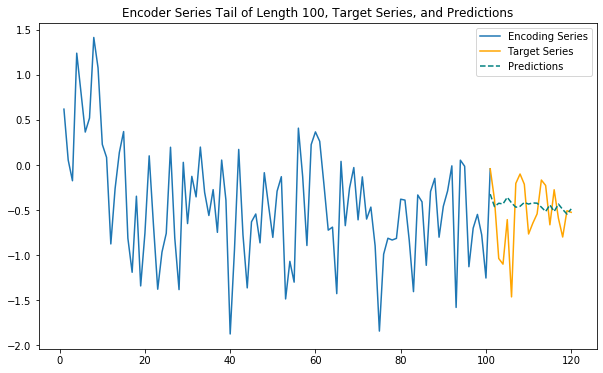

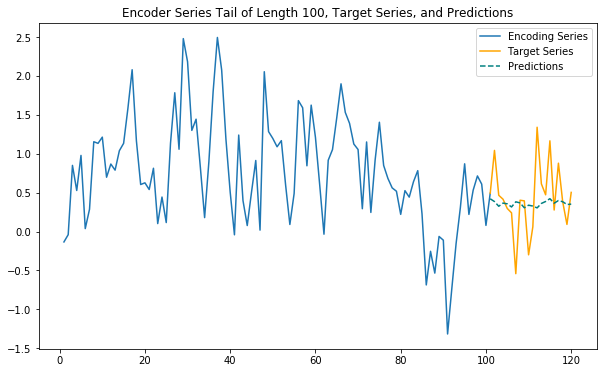

In [24]:
for i in top_k_mae:
    predict_and_plot(val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=20)

In [13]:
val_paths[0]

'/projects/HASSON/247/data/binned_conversations/676_bin_norm_2/bin_norm_2_NY676_619_Part3_conversation2/bin_norm_2_NY676_619_Part3_conversation2.npy'

In [39]:
seq_generator = generators.FGenerator(file_paths=[val_paths[0]],
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False)

In [40]:
len(seq_generator)

1

In [41]:
len(seq_generator[0][0])

1024

In [42]:
data = np.load(val_paths[0])

In [52]:
data.shape

(131266, 114)

In [58]:
history_len = int(data.shape[0] * 0.8)

In [59]:
history_len

105012

In [116]:
def predict_sequence_o2o_window(input_sequence, pred_steps, model, lookback=lookback):
    history_sequence = input_sequence.reshape((1, lookback, 1))
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)
        last_step_pred = last_step_pred.reshape(-1)

        pred_sequence[i] = last_step_pred[-1]
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           last_step_pred[-1].reshape(1, 1, 1)], axis=1)

    return pred_sequence

def moving_window_pred_o2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], electrode_count))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end]
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end]
        pred_seq = predict_sequence_o2o_window(window_lookback, pred_steps, model, lookback=lookback)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, electrode_count)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    input_seq = input_seq[:,electrode].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_o2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              electrode_count=electrode_count,
                                              model=model)
    
    input_seq = input_seq[lookback:,:]

    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

(2000, 1)
Correlation: 0.4384032075542702. P: 4.493644824808361e-90. MAE: 0.6261706404059476


(0.4384032075542702, 0.6261706404059476)

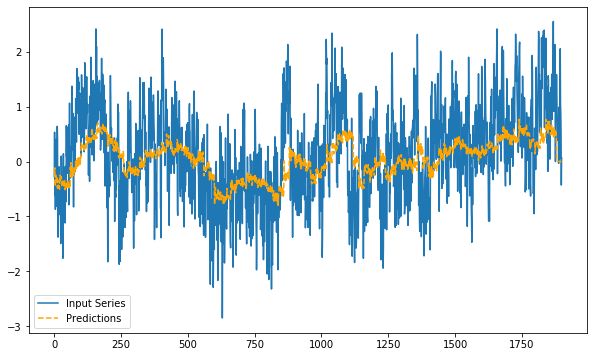

In [118]:
get_corr_mae_conv(data[:2000,:], lookback, pred_length, electrode_count=1, electrode=electrode, model=model)